Order of Code

For SAE it should go
1. Define sizes and layers
2. Initialize weights (use tied weights and 1 b per layer)
3. pre_train each level of depth. 
    Basically plug in SGD for that layer for a certain number of epochs.
        Return w,b
        do feedforawrd to get input for next pretrain level
        return w,b
    repeat this until all are pretrained.
    
    

In [77]:
import numpy as np
# Note: all of this will be done with full-batch implementation. No regularization yet. No sparcity yet
import mnist_loader

import matplotlib.pyplot as plt
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()




In [78]:
training_data_segment = list(training_data)[:100]
unlabeled_data = np.array([data[0] for data in training_data_segment])
data = unlabeled_data.T.reshape(784,-1) # each example stored in a column

test_data_segment = list(test_data)[:10]
unlabeled_test_data = np.array([data[0] for data in test_data_segment])
test_data = unlabeled_test_data.T.reshape(784,-1) # each example stored in a colum

In [79]:
%matplotlib inline

In [80]:
def sigmoid(x):
#     print('max of x array is ' + str(np.amax(x)))
#     print('min of x is ' + str(np.amin(x)))
    return 1/(1+np.exp(-x))

def sp(sigma):
	return sigma*(1-sigma)

def get_minibatches(data, mb_length):
    '''Takes in data as np.array, with egs in columns and outputs examples in columns as np.array()'''
#     random.shuffle(data)  I think this will screw it up with data in columns
    data = data.T
    minibatches = [data[i:i+mb_length] for i in range(0,len(data),mb_length)] #means the last minibatch could be shorter
    return np.array(minibatches)

def get_rho_hat(data, w, b):
    a_hidden, a_out = feedforward(data,w,b)
    rho_hat = np.sum(a_hidden, axis = 1).reshape(len(a_hidden),1)/data.shape[1]
    return rho_hat

def feedforward(x, w, b):  # Note: all of this will be done with full-batch implementation. No regularization yet. No sparcity yet
    # x should have examples in columns!
    a_hidden = sigmoid(np.dot(w,x)+b[0])
    a_out = sigmoid(np.dot(w.transpose(),a_hidden)+b[1])
    return [a_hidden, a_out] # Examples are still stored in columns in the hidden layer
# B's will work, I just need to be careful when I recreate images.

# def backprop(x, w, b):
#     a_hidden, a_out = feedforward(x,w,b)
#     d_out = (a_out-x)*sp(a_out) # Using quad-cost for now
#     d_hidden = np.dot(w,d_out)*sp(a_hidden)

#     #dW_jk = a_k_l-1 * d_j
#     dC_dw_T = np.dot(d_out, a_hidden.transpose())
#     dC_dw_input = np.dot(d_hidden, x.transpose())

#     dC_dw = dC_dw_input+dC_dw_T.transpose()
#     dC_db = [np.sum(d_hidden, axis = 1).reshape(b[0].shape), np.sum(d_out, axis = 1).reshape(b[1].shape)] # put these in cells of a matrix
#     return dC_dw, dC_db


def backprop(x,w,b,rho,beta, rho_hat, sparse):
    a_hidden, a_out = feedforward(x,w,b)
    
    if sparse:
        KL_deriv = (beta*(-(rho/rho_hat)+((1-rho)/(1-rho_hat)))).reshape(len(a_hidden),1)
    else:
        KL_deriv = 0
        
    d_out = (a_out-x)*sp(a_out)

    d_hidden = (np.dot(w,d_out)+KL_deriv)*sp(a_hidden)

    dC_dw_T = np.dot(d_out, a_hidden.transpose())
    dC_dw_input = np.dot(d_hidden, x.transpose())

    dC_dw = dC_dw_input+dC_dw_T.transpose()
    dC_db = [np.sum(d_hidden, axis = 1).reshape(b[0].shape), np.sum(d_out, axis = 1).reshape(b[1].shape)] # put these in cells of a matrix
    return dC_dw, dC_db, rho_hat

def update_net(data,w,b,eta,mb_length,lmbda = 0,rho = 0, beta = 0, sparse = 0):
    if sparse:
        # if it's sparse, we need to get rho_hat
        rho_hat = get_rho_hat(data,w,b)
    else:
        rho_hat = [0,0]
    
    ### weight decay term here.
    
        
    mbs = get_minibatches(data,mb_length)
    for mb in mbs:
        dC_dw, dC_db, rho_hat = backprop(mb.T, w, b,rho,beta,rho_hat,sparse)
        # Using gradient descent - lmbda/data.shape[1]*w
        w = w - (eta/mb.shape[1])*dC_dw - w*lmbda
        b[0] = b[0] - (eta/mb.shape[1])*dC_db[0]
        b[1] = b[1] - (eta/mb.shape[1])*dC_db[1]
        
    return w,b,rho_hat

def eval_err(data,w,b):
    prediction = feedforward(data,w,b)
    error = sum(sum((prediction[1] - data)**2))/(data.shape[1])
    return error


def SGD_sparse(data,test_data,w,b,epochs,eta,mb_length,report_freq,lmbda = 0,sparse = 0,rho = 0,beta = 0):
    rho_hat_avg = []
    for i in range(epochs):
        w,b,rho_hat = update_net(data,w,b,eta,mb_length,lmbda,rho,beta,sparse) # updates over entire epoch
        rho_hat_avg.append(sum(rho_hat)/len(rho_hat))
        if i%report_freq == 0:
            print(eval_err(test_data,w,b))    
    
    return w,b,rho_hat_avg,rho_hat

# Now define the stacked autoencoder functions

def pretrain_layer(inputs,test_inputs,w,b,epochs,eta,mb_length,report_freq,lmbda = 0,sparse = 0,rho = 0,beta = 0): # note that w and b are only for that layer
    w,b,rho_hat_avg,rho_hat = SGD_sparse(inputs,test_inputs,w,b,epochs,eta,mb_length,report_freq,lmbda,sparse = 0,rho = 0,beta = 0)
    return w,b


def full_feedforward(data,w,b):
    h1 = sigmoid(np.dot(w[0],data)+b[0])
    h2 = sigmoid(np.dot(w[1],h1) + b[1])
    h3 = sigmoid(np.dot(w[1].T,h2) + b[2])
    out = sigmoid(np.dot(w[0].T,h3) + b[3])
    return h1,h2,h3,out

def full_err(data, w, b):
    layers = full_feedforward(data,w,b)
    error = sum(sum((layers[-1]-data)**2))/data.shape[1]
    return error
    
def full_bp(x,w,b,rho,beta, rho_hat, sparse):
    '''Assuming the network is 5 layers total. Its hard coded
    Note that rho_hat, beta, and rho will be vectors with 1 entry per layer now'''
    a = full_feedforward(x,w,b)
    
    if sparse:
        KL_deriv = []
        for i in range(len(rho_hat)): #note that rho_hat will be 1 shorter than a
            KL_deriv.append(beta*(-(rho[i]/rho_hat[i])+((1-rho[i])/(1-rho_hat[i])))).reshape(len(a[i]),1)
#         KL_deriv = (beta*(-(rho/rho_hat)+((1-rho)/(1-rho_hat)))).reshape(len(a_hidden),1)
    else:
        KL_deriv = [0,0,0]
        
    d_out = (a[-1]-x)*sp(a[-1])
    d_h3 = (np.dot(w[0],d_out)+KL_deriv[-1])*sp(a[-2])
    d_h2 = (np.dot(w[1],d_h3)+KL_deriv[-2])*sp(a[-3])
    d_h1 = (np.dot(w[1].T,d_h2)+KL_deriv[-3])*sp(a[-4])

    dC_dw_0_T = np.dot(d_out, a[-2].transpose())
    dC_dw_0_input = np.dot(d_h1, x.transpose())
    
    dC_dw_1_T = np.dot(d_h3, a[-3].transpose())
    dC_dw_1_input = np.dot(d_h2, a[-4].transpose())

    dC_dw_0 = dC_dw_0_input+dC_dw_0_T.transpose()
    dC_dw_1 = dC_dw_1_input + dC_dw_1_T.transpose()
    dC_db = [np.sum(d_h1, axis = 1).reshape(b[0].shape), 
            np.sum(d_h2, axis = 1).reshape(b[1].shape),
            np.sum(d_h3, axis = 1).reshape(b[2].shape),
            np.sum(d_out,axis = 1).reshape(b[3].shape)] # put these in cells of a matrix
    dC_dw = [dC_dw_0,dC_dw_1]
    return dC_dw, dC_db, rho_hat #note: bpshouldn't have to return rho_hat anymore...

# def finetune_net():
def update_net_full(data,w,b,eta,mb_length,lmbda = 0,rho = 0, beta = 0, sparse = 0):
    if sparse:
        # if it's sparse, we need to get rho_hat
        rho_hat = get_rho_hat(data,w,b)
    else:
        rho_hat = [0,0,0]
    
    ### weight decay term here.
    
        
    mbs = get_minibatches(data,mb_length)
    for mb in mbs:
        dC_dw, dC_db, rho_hat = full_bp(mb.T, w, b,rho,beta,rho_hat,sparse)
        # Using gradient descent - lmbda/data.shape[1]*w
        w[0] = w[0] - (eta/mb.shape[1])*dC_dw[0] - w[0]*lmbda
        w[1] = w[1] - (eta/mb.shape[1])*dC_dw[1] - w[1]*lmbda
        for i in range(4):
            b[i] = b[i] - (eta/mb.shape[1])*dC_db[i]
        
    return w,b,rho_hat

def SGD_sparse_full(data,test_data,w,b,epochs,eta,mb_length,report_freq,lmbda = 0,sparse = 0,rho = 0,beta = 0):
    rho_hat_avg = []
    for i in range(epochs):
        w,b,rho_hat = update_net_full(data,w,b,eta,mb_length,lmbda,rho,beta,sparse) # updates over entire epoch
        rho_hat_avg.append(sum(rho_hat)/len(rho_hat))
        if i%report_freq == 0:
            print(full_err(test_data,w,b))    
    
    return w,b,rho_hat_avg,rho_hat

def compare_image(test_data,image_num, w, b):
    output = full_feedforward(test_data.T[image_num].reshape(784,1),w,b)
    output = np.array(output[1])
    # print(output.shape)

    plt.imshow(np.array(output).reshape(28,28))
    plt.title('Predicted output')
    plt.show()

    plt.figure()
    plt.imshow(np.array(test_data.T[image_num].reshape(28,28)))
    plt.title('Original Number')
    plt.show()

    plt.figure()
    plt.imshow(np.array(test_data.T[image_num].reshape(28,28))-np.array(output).reshape(28,28))
    plt.title('difference between predicted and original')
    plt.show()

In [82]:
# define layers and parameters
hidden_size_1 = 50
hidden_size_2 = 50
sizes = [784,hidden_size_1,hidden_size_2,hidden_size_1,784]
b= [np.zeros((hidden_size_1,1)),
    np.zeros((hidden_size_2,1)),
    np.zeros((hidden_size_1,1)),
    np.zeros((784,1))]

w_1 = np.random.randn(sizes[1],sizes[0])/np.sqrt(sizes[0])
w_2 = np.random.randn(sizes[2],sizes[1])/np.sqrt(sizes[1])

rho = 0.05
beta = 0
mb_length = 20
eta = 5
lmbda = 0.0

epochs = 400
report_freq = int(epochs/8) #will round down

# # start coding
b_first = [b[0],b[-1]]
w_1,b_first = pretrain_layer(data,test_data,w_1,b_first,epochs,eta,mb_length,report_freq,lmbda,sparse = 0,rho = 0,beta = 0) # note that w and b are only for that layer

hidden_inputs, discard = feedforward(data,w_1,b_first)
print('\n')
b_second = [b[1],b[2]] # This is b for the inner.
w_2,b_second = pretrain_layer(hidden_inputs,hidden_inputs,w_2,b_second, epochs ,10,mb_length,report_freq,lmbda,sparse = 0,rho = 0,beta = 0) # note that w and b are only for that layer
# both layers seem to be pretraining well. 
print('\n')

# okay, this isn't working yet.
b = [b_first[0],b_second[0],b_second[1],b_first[1]]
# I think I have b wrong.
w = [w_1,w_2]
layers = full_feedforward(data,w,b)
print('avg SSE between data and prediction = ' + str(full_err(data,w,b)))

w,b,rho_hat_avg,rho_hat = SGD_sparse_full(data,test_data,w,b,epochs,5,mb_length,report_freq,lmbda,sparse = 0,rho = 0,beta = 0)


98.772925893
36.908439225
31.8217481501
29.2119670043
27.9276889189
27.272858041
27.0065754094
26.8679562134


8.42716769653
0.237351101667
0.111123122748
0.0659286365242
0.0487428267369
0.0388934564738
0.0326909467414
0.0284308021774


avg SSE between data and prediction = 10.0053371174
30.0897187526
30.8118082633
31.3866478584
31.7597261016
32.0261561475
32.2394051917
32.413522633
32.5744939006


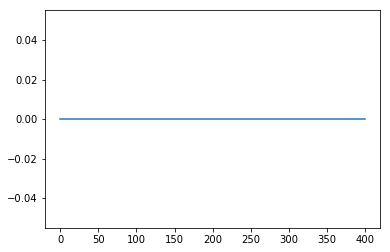

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(len(rho_hat_avg)),rho_hat_avg)
plt.show()

# Interesting, with minibatch approach, it doesn't overshoot. I think that's because it's not reported every minibatch, but 
#Instead once per epoch.

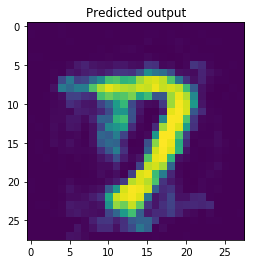

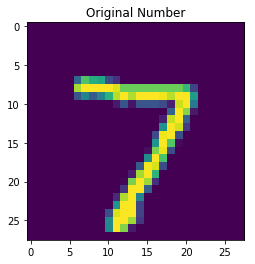

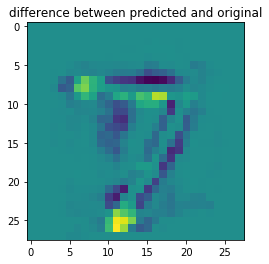

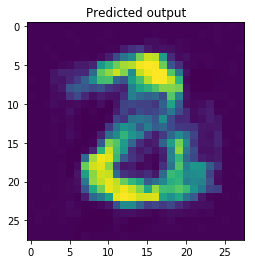

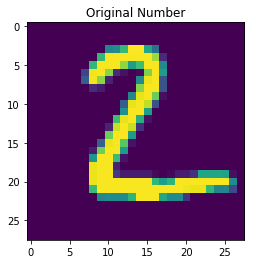

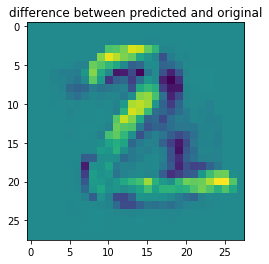

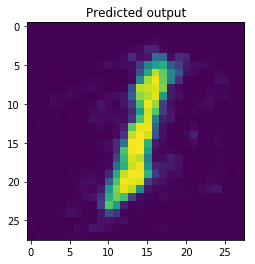

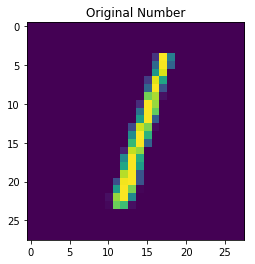

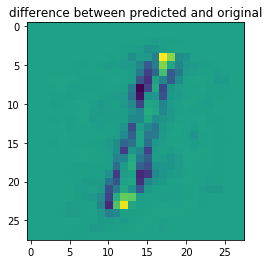

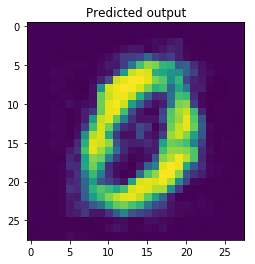

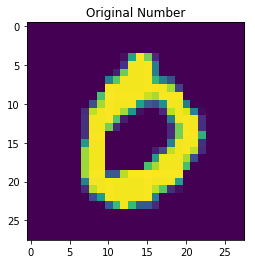

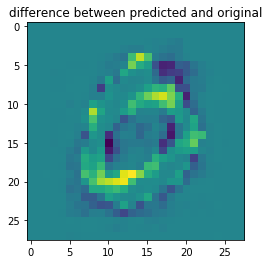

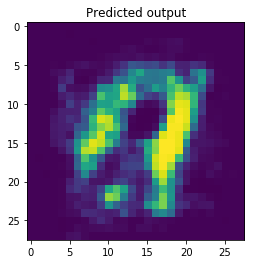

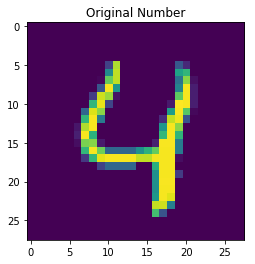

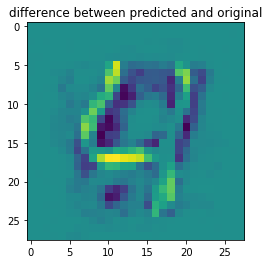

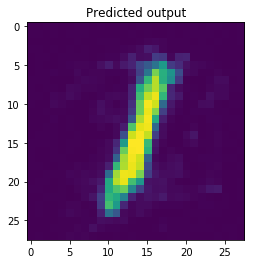

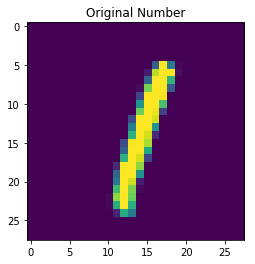

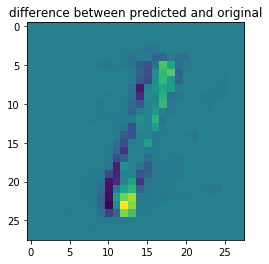

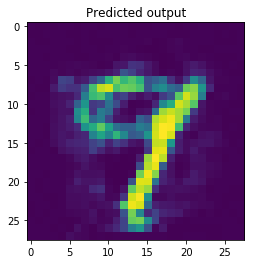

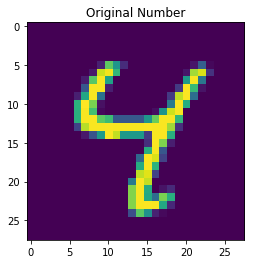

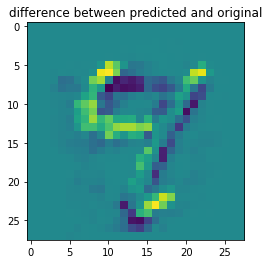

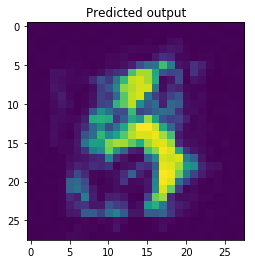

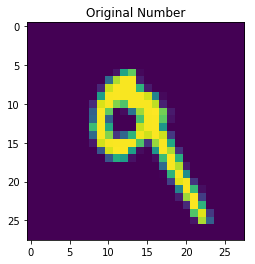

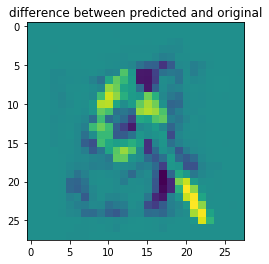

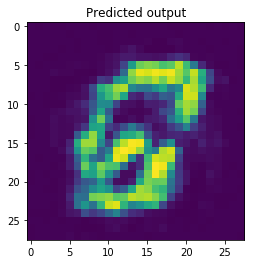

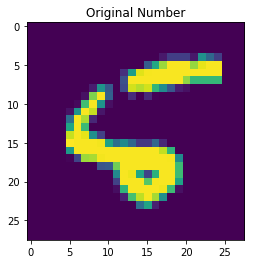

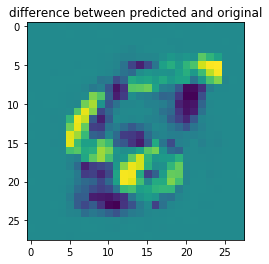

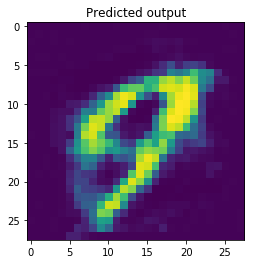

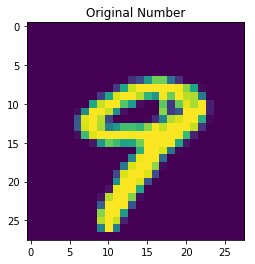

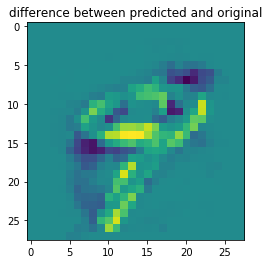

In [83]:
# digit = 6
for digit in range(10):
    output = full_feedforward(test_data.T[digit].reshape(784,1),w,b) # Have to transpose becasue egs are in columns.
    # print(data.T[0].shape)
    output = np.array(output[-1])
    # print(output.shape)

    plt.imshow(np.array(output).reshape(28,28))
    plt.title('Predicted output')
    plt.show()

    plt.figure()
    plt.imshow(np.array(test_data.T[digit].reshape(28,28)))
    plt.title('Original Number')
    plt.show()

    plt.figure()
    plt.imshow(np.array(test_data.T[digit].reshape(28,28))-np.array(output).reshape(28,28))
    plt.title('difference between predicted and original')
    plt.show()

3
3
3
3
3
3
3
3
3
3


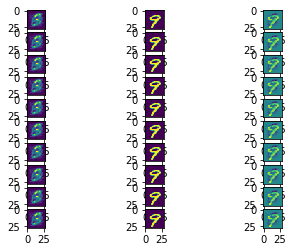

In [99]:

figure, axes = plt.subplots(10,3)
counter = 0
for axis in axes:
    print(len(axis))
    for digit in range(10):
        output_s = feedforward(test_data.T[digit].reshape(784,1),w,b) # Have to transpose becasue egs are in columns.
        output_s = np.array(output_s[1])
    
        image = axis[0].imshow(np.array(output_s).reshape(28,28))
#         axis.set_frame_on(False)
#         axis.set_axis_off()

        image = axis[1].imshow(np.array(test_data.T[digit].reshape(28,28)))
#         axis.set_frame_on(False)
#         axis.set_axis_off()
        
        image = axis[2].imshow(np.array(test_data.T[digit].reshape(28,28))-np.array(output_s).reshape(28,28))
#         axis.set_frame_on(False)
#         axis.set_axis_off()
plt.show()



    

In [75]:
mbs = get_minibatches(test_data,3)
print(mbs.shape)
print(mbs.shape[-1])
for mb in mbs:
    print(mb.T.shape)
# it's not going well if it's not a remainder of 0.
# Oh, it's actually not a problem. It's just a smaller mb. That's fine...
# for i in range(c.shape[-1]):
#     print c[...,i]
# Okay, actually, arrays are terrible for this kinda thing.

(4,)
4
(784, 3)
(784, 3)
(784, 3)
(784, 1)


In [36]:
print(test_data.T[1:5000].shape)

(9, 784)


Dang, the single layer AE is far better, for now.

Acutally, I think somethin is even wrong with my pretraining. The way I see it, pretraining the first layer should be exactly the same as training my single layer AE, yet for now, it's performing just a little worse. Maybe that means full batch is better?

I think ideally in future code, I won't write so many functions, because I'll do a generalized "train AE" function that handles all depths, with for loops and such.